In [7]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm

goal='sync'
bifurcation='low'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 5 nodes
A = parameters['A'][:5,:5]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = 5


#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-np.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=np.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [12]:
parameters

{'alpha': 3.0,
 'beta': 4.0,
 'gamma': 1.5,
 'delta': 0,
 'epsilon': 0.5,
 'tau': 20.0,
 'sigma': 0.025,
 'mu': 0.7,
 'A': array([[0.        , 0.03152394, 0.08882945, 0.02200945, 0.14447569],
        [0.03152394, 0.        , 0.00879103, 0.09211654, 0.00310815],
        [0.08882945, 0.00879103, 0.        , 0.04622159, 0.35932581],
        [0.02200945, 0.09211654, 0.04622159, 0.        , 0.03381711],
        [0.14447569, 0.00310815, 0.35932581, 0.03381711, 0.        ]]),
 'N': 5}

In [8]:
functional=functions.f_sync
gradient=functions.fprime_sync

#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])
print('Code finished after ',iteration,' iterations with warnflag',result[2])  

gnorm 5.521482813886502e-05 uknorm 7.491157745813593e-06
Iteration  29  finished at gnorm 5.521482813886502e-05 with f 4.867772658368932e-06 with warnflag 0
Code finished after  29  iterations with warnflag 0


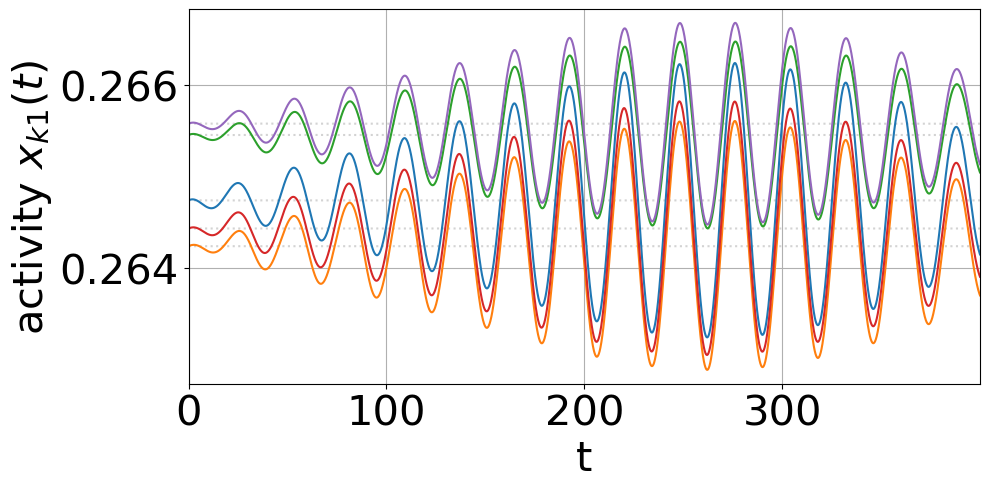

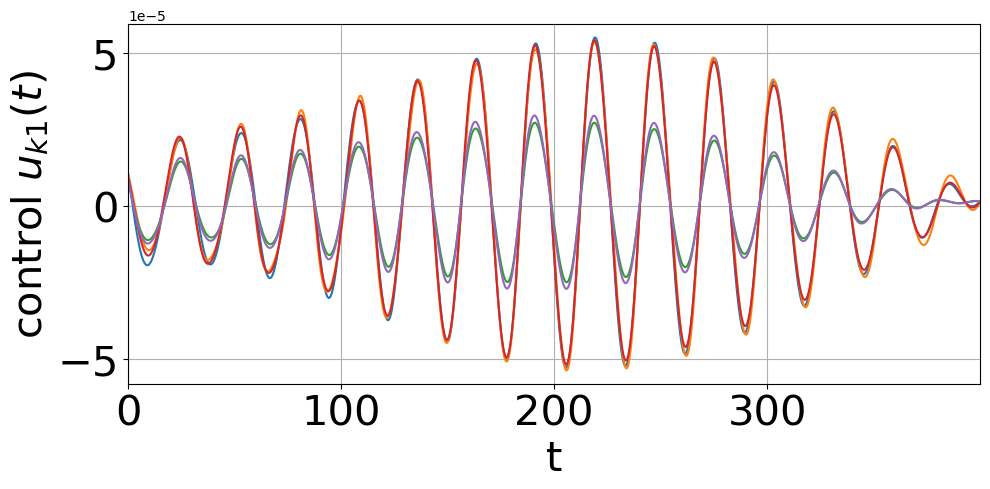

In [9]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(state_controlled[:,0,:])
maxx=np.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(np.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(np.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(control)
maxx=np.max(control)
add=(maxx-minn)/25

im1=ax.plot(np.arange(0,int(T),dt),control)
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


